In [ ]:
# importo librerías
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Prepocessing & Utils.
import sklearn
from sklearn.compose import ColumnTransformer

# Modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

#Metricas
from sklearn.metrics import accuracy_score, auc, confusion_matrix, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
# ingesto datos
df = pd.read_csv('/content/telco_churn_clusterai.csv')
df.head(10)
df.shape

(7043, 22)

In [ ]:
# dropeo ids
df = df.drop(columns=['Unnamed: 0', 'customerID'])

In [ ]:
df['SeniorCitizen'] = df['SeniorCitizen'].replace({0.0: 'No', 1.0: 'Yes'})
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,NaN,Yes,No,1.0,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,NaN,Electronic check,29.85,29.85,No
1,Male,No,No,No,34.0,Yes,No,NaN,Yes,No,Yes,No,No,No,One year,No,Mailed check,NaN,1889.50,No
2,Male,No,No,No,2.0,NaN,No,NaN,Yes,NaN,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,No,No,No,NaN,No,NaN,NaN,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,NaN,NaN,NaN,2.0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,151.65,Yes


In [ ]:
# Definimos las variables de entrenamiento y objetivo.
features = ["TotalCharges", "tenure", "MonthlyCharges", "SeniorCitizen", "Partner", "Dependents", "PhoneService", "MultipleLines", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "PaperlessBilling", "gender", "InternetService", "Contract", "PaymentMethod"]
target = ['Churn']
# Generamos X e Y
X = df.loc[:,features]
Y = df.loc[:,target]

# Spliteamos Train y test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [ ]:
for column in df.columns:
    if df[column].dtype == 'object':
        print(f"Column '{column}': {df[column].unique()}")

Column 'gender': ['Female' 'Male' nan]
Column 'SeniorCitizen': [nan 'No' 'Yes']
Column 'Partner': ['Yes' 'No' nan]
Column 'Dependents': ['No' nan 'Yes']
Column 'PhoneService': ['No' 'Yes' nan]
Column 'MultipleLines': ['No phone service' 'No' nan 'Yes']
Column 'InternetService': ['DSL' nan 'Fiber optic' 'No']
Column 'OnlineSecurity': ['No' 'Yes' nan 'No internet service']
Column 'OnlineBackup': ['Yes' 'No' nan 'No internet service']
Column 'DeviceProtection': ['No' 'Yes' 'No internet service']
Column 'TechSupport': ['No' 'Yes' 'No internet service']
Column 'StreamingTV': ['No' 'Yes' 'No internet service']
Column 'StreamingMovies': ['No' 'Yes' 'No internet service']
Column 'Contract': ['Month-to-month' 'One year' nan 'Two year']
Column 'PaperlessBilling': [nan 'No' 'Yes']
Column 'PaymentMethod': ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)' nan]
Column 'Churn': ['No' 'Yes']


In [ ]:
# Diferenciemos los tipos de variables (numericas, categoricas y categóricas booleanas)
varaibles_num = ["TotalCharges", "tenure", "MonthlyCharges"]
variables_bool = ["SeniorCitizen", "Partner", "Dependents", "PhoneService", "MultipleLines", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "PaperlessBilling"]
variables_cat = ["gender", "InternetService", "Contract", "PaymentMethod"]


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
# Definamos las transformaciones para cada tipo de variable:
transformacion_num = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", MinMaxScaler())]
)

# La idea aca es transformar los valores "Yes" a 1, y todo lo otro a "0" después de hacer el simpleimputer
class BinaryEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        # X will be a numpy array from SimpleImputer
        # Convert 'Yes' to 1 and 'No' to 0 using numpy.where
        return np.where(X == 'Yes', 1, 0).astype(int)

transformacion_bool = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")), ("encoder", BinaryEncoder())]
)

transformacion_cat = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")), ("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

In [ ]:
# Juntemas todo:
preprocesamiento = ColumnTransformer(
    # (nombre,transformacion, columnas )
    transformers=[
        ("num", transformacion_num, varaibles_num),
        ("bool", transformacion_bool, variables_bool),
        ("cat", transformacion_cat, variables_cat),
    ]
)

In [ ]:
X_train_transformed = preprocesamiento.fit_transform(X_train)
X_test_transformed = preprocesamiento.transform(X_test)

# Get feature names for numerical features
num_feature_names = varaibles_num

# Get feature names for boolean features (after encoding they are just 'SeniorCitizen', 'Partner', etc.)
bool_feature_names = variables_bool

# Get feature names for categorical features (after one-hot encoding)
# The OneHotEncoder is the last step in the 'cat' pipeline
onehot_encoder = preprocesamiento.named_transformers_['cat'].named_steps['onehot']
cat_feature_names = onehot_encoder.get_feature_names_out(variables_cat)

# Combine all feature names
all_feature_names = num_feature_names + bool_feature_names + list(cat_feature_names)

# Create a DataFrame from the transformed data
X_train_processed_df = pd.DataFrame(X_train_transformed, columns=all_feature_names)
X_test_processed_df = pd.DataFrame(X_test_transformed, columns=all_feature_names)

print("Shape of transformed X_train data:", X_train_transformed.shape)
print("First 5 rows of transformed X_train data:")
display(X_train_processed_df.head())

print("\nShape of transformed X_test data:", X_test_transformed.shape)
print("First 5 rows of transformed X_test data:")
display(X_test_processed_df.head())

Shape of transformed X_train data: (5634, 27)
First 5 rows of transformed X_train data:


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


,TotalCharges,tenure,MonthlyCharges,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.708122,1.000000,0.663668,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.075450,0.194444,0.276362,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.206752,0.986111,0.059970,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.275354,0.458333,0.551724,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.520987,0.652778,0.800100,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0



Shape of transformed X_test data: (1409, 27)
First 5 rows of transformed X_test data:


,TotalCharges,tenure,MonthlyCharges,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.118441,0.263889,0.394803,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.811296,0.833333,0.978511,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.104432,0.180556,0.532234,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.000185,0.013889,0.517241,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.490142,0.402778,0.590205,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
Y_train = Y_train.replace({'Yes': 1, 'No': 0}).astype(int)
Y_test = Y_test.replace({'Yes': 1, 'No': 0}).astype(int)

print("Y_train transformed:")
display(Y_train.head())

print("\nY_test transformed:")
display(Y_test.head())

Y_train transformed:


/tmp/ipython-input-2287473759.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y_train = Y_train.replace({'Yes': 1, 'No': 0}).astype(int)
/tmp/ipython-input-2287473759.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y_test = Y_test.replace({'Yes': 1, 'No': 0}).astype(int)


,Churn
2920,0
2966,0
6099,0
5482,1
2012,1



Y_test transformed:


,Churn
2200,0
4627,0
3225,0
2828,0
3768,0


In [ ]:
import google.colab.files

# Save and download X_train_processed_df
X_train_processed_df.to_csv('X_train_processed.csv', index=False)
google.colab.files.download('X_train_processed.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save and download X_test_processed_df
X_test_processed_df.to_csv('X_test_processed.csv', index=False)
google.colab.files.download('X_test_processed.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save and download Y_train
Y_train.to_csv('Y_train.csv', index=False)
google.colab.files.download('Y_train.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save and download Y_test
Y_test.to_csv('Y_test.csv', index=False)
google.colab.files.download('Y_test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Hasta este punto se realizaron las manipulaciones sobre el modelo de datos para entrenar los modelos de machine learning.
A continuación, ejecutaremos una reducción de dimensionalidad.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=6)

# Fit PCA to the training data and transform it
X_train_pca = pca.fit_transform(X_train_processed_df)

# Transform the test data using the fitted PCA model
X_test_pca = pca.transform(X_test_processed_df)

print("Shape of X_train_pca:", X_train_pca.shape)
print("Shape of X_test_pca:", X_test_pca.shape)

Shape of X_train_pca: (5634, 6)
Shape of X_test_pca: (1409, 6)


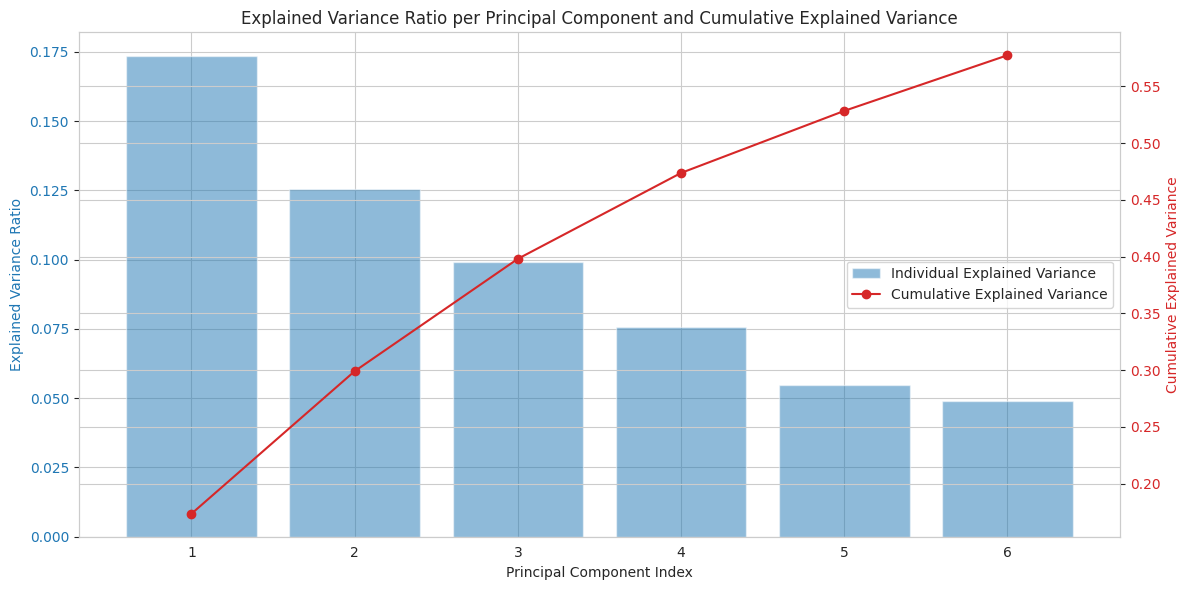

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate cumulative explained variance ratio
cum_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot individual explained variance ratio as bars
ax1.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.5, label='Individual Explained Variance')
ax1.set_xlabel('Principal Component Index')
ax1.set_ylabel('Explained Variance Ratio', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a twin y-axis for cumulative explained variance
ax2 = ax1.twinx()
ax2.plot(range(1, len(cum_explained_variance) + 1), cum_explained_variance, color='tab:red', marker='o', label='Cumulative Explained Variance')
ax2.set_ylabel('Cumulative Explained Variance', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Set title and add legend
plt.title('Explained Variance Ratio per Principal Component and Cumulative Explained Variance')
fig.tight_layout() # Adjust layout to prevent labels from overlapping

# Add legend from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center right')

plt.show()

In [ ]:
# Get the absolute values of the PCA components (loadings)
absolute_loadings = np.abs(pca.components_)

# Calculate the sum of absolute loadings for each original feature
# This represents the overall importance of each feature across all principal components
feature_importances = np.sum(absolute_loadings, axis=0)

# Create a DataFrame for better visualization and sorting
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

print("Original Feature Importance based on PCA Loadings (Ordered by Importance):")
display(feature_importance_df)

Original Feature Importance based on PCA Loadings (Ordered by Importance):


,Feature,Importance
0,Partner,1.590889
1,PaymentMethod_Electronic check,1.586237
2,Contract_Month-to-month,1.355377
3,InternetService_Fiber optic,1.275321
4,Dependents,1.100058
5,InternetService_DSL,1.037738
6,InternetService_No,0.872871
7,gender_Male,0.777697
8,gender_Female,0.777697
9,Contract_Two year,0.740262


### Download PCA transformed data

In [ ]:
# Convert X_train_pca to DataFrame and save/download
X_train_pca_df = pd.DataFrame(X_train_pca)
X_train_pca_df.to_csv('X_train_pca.csv', index=False)
google.colab.files.download('X_train_pca.csv')

# Convert X_test_pca to DataFrame and save/download
X_test_pca_df = pd.DataFrame(X_test_pca)
X_test_pca_df.to_csv('X_test_pca.csv', index=False)
google.colab.files.download('X_test_pca.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>